In [1]:
# import 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.stats import laplace

In [2]:
# draw:
def plt_show(title,img,cmap = None):
    fig = plt.figure()
    plt.title(title)
    plt.imshow(img,cmap=cmap)
    plt.show()

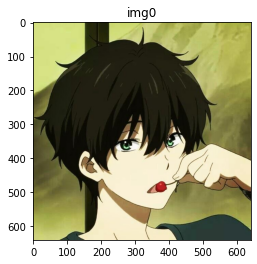

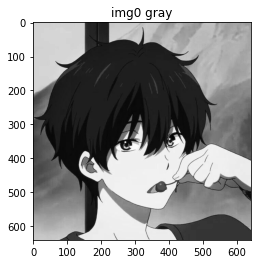

In [3]:
# load img:
img0 = cv2.imread('ori.jpg')
# show:
img0_gray = cv2.cvtColor(img0,cv2.COLOR_BGR2GRAY)
img0_color = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
plt_show("img0",img0_color)
plt_show("img0 gray",img0_gray,cmap="gray")

In [4]:
kernel = 1/16*np.array([1,4,6,4,1])
level = 4

In [5]:
# transfer int to uint:
def int2uint(number):
    if len(number.shape)>1:
        number[number<0] = 0
        number[number>255] = 255
        return number.astype('uint8')

In [6]:
# 对图像构建高斯金字塔：
def gauss_pyramid(img,level):
    gauss_pyr = []
    img_c = copy.deepcopy(img)
    # 放原图作为第零层：
    gauss_pyr.append(img_c)
    for i in range(level):
        img_c = cv2.pyrDown(img_c)
        plt_show("gauss pyr layer = {}".format(i+1),img_c,cmap="gray")
        gauss_pyr.append(img_c)
    return gauss_pyr

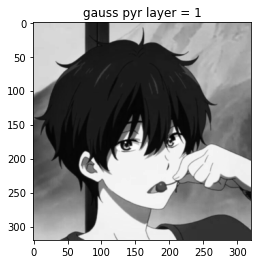

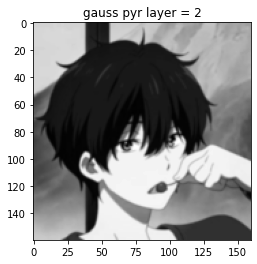

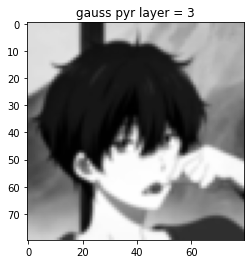

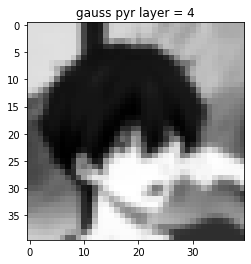

In [7]:
img0_gauss_pyr = gauss_pyramid(img0_gray,level)

In [8]:
# 拉普拉斯金字塔：
def lap_pyramid(gauss_pyr,level):
    lap_pyr = []
    for i in range(1,level+1):
        # expand:
        temp = cv2.pyrUp(gauss_pyr[i]) 
        # substract:
        width = min(gauss_pyr[i-1].shape[0],temp.shape[0])
        length = min(gauss_pyr[i-1].shape[1],temp.shape[1])
        a = np.array(gauss_pyr[i-1][:width,:length],dtype='int')
        b = np.array(temp[:width,:length],dtype='int')
        sub = a-b
        plt_show("lap lay={}".format(i-1),sub,cmap="gray")
        lap_pyr.append(sub)
    lap_pyr.append(gauss_pyr[level])
    return lap_pyr

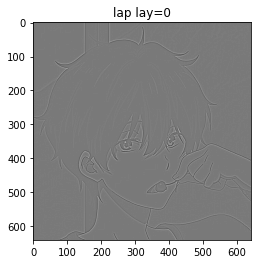

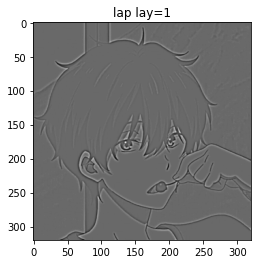

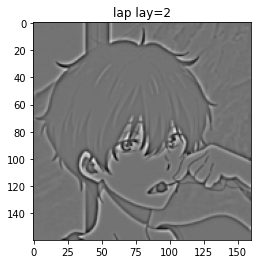

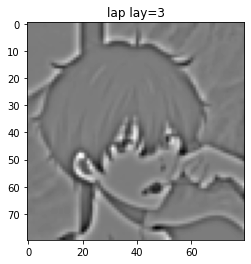

In [9]:
img0_lap_pyr =  lap_pyramid(img0_gauss_pyr,level)

In [10]:
# 对直方图进行统计：
def histogram(lap_pyramid):
    histogram = []
    min_l = []
    max_l = []
    for i in range(len(lap_pyramid)):
        temp = np.array(lap_pyramid[i],dtype='float32')
        min = np.min(temp)
        max = np.max(temp)
        size = int(max-min+1)
        hist = cv2.calcHist([temp],[0],None,histSize=[size],ranges=[min,max])
        plt.figure()
        plt.plot(np.arange(min,max+1),hist)
        # plt.hist(temp,size,True)
        histogram.append(hist)
        min_l.append(min)
        max_l.append(max)
    return histogram,min_l,max_l

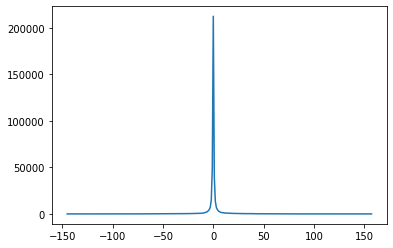

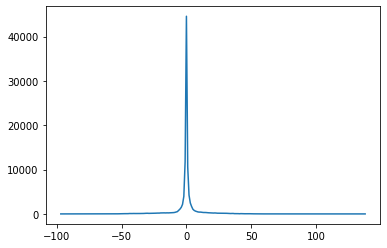

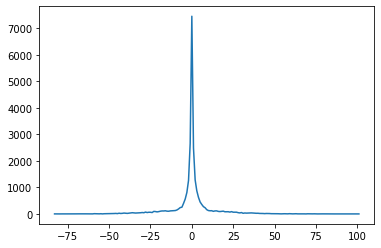

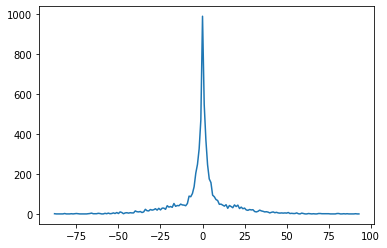

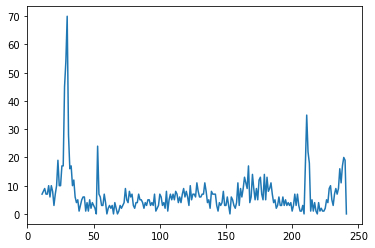

In [11]:
hist,min_l,max_l = histogram(img0_lap_pyr)

In [12]:
# 对图像加入高斯噪声：
def add_GaussNoise(img,mean=0,std=0.5):
    # 归一化
    img = np.array(img/255,dtype='float')
    # 添加高斯噪声
    noise = np.random.normal(mean,std,img.shape)
    out_img = img+noise

    # 限制值：
    out_img = np.clip(out_img,a_min=0,a_max=1)
    # 返回
    out = np.uint8(out_img*255)
    plt_show("add Noise",out,cmap="gray")
    return out

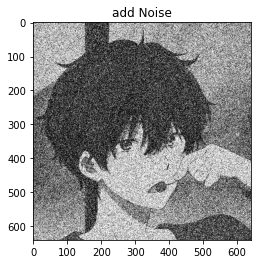

In [13]:
img00_gray = add_GaussNoise(img0_gray)

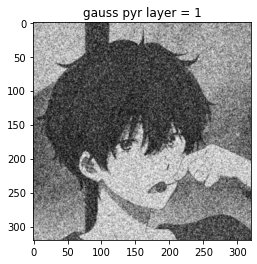

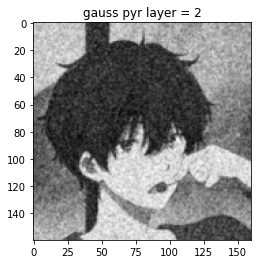

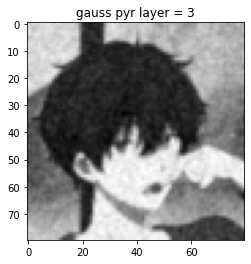

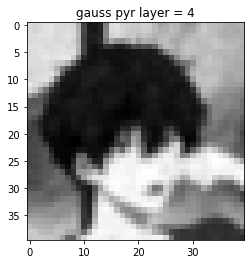

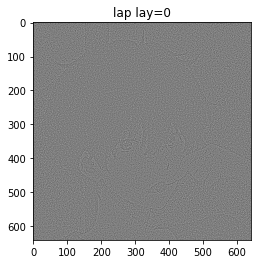

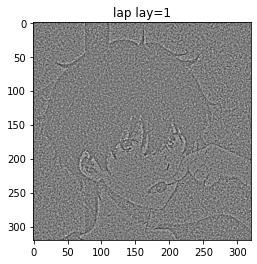

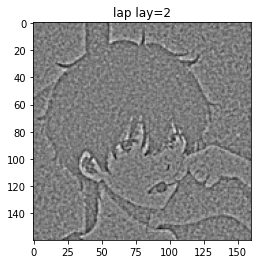

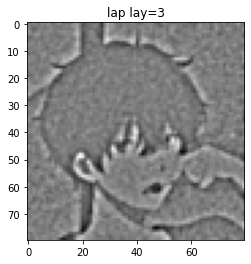

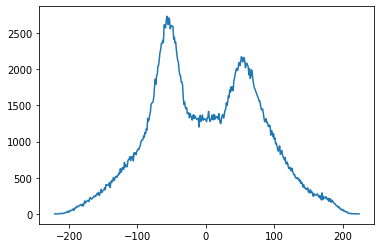

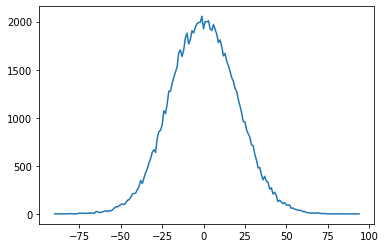

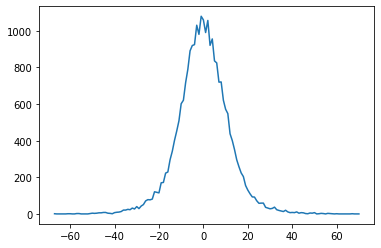

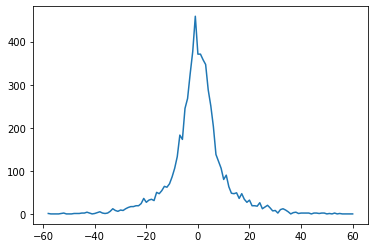

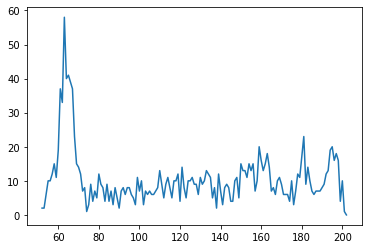

In [14]:
# 重试
img00_gauss_pyr = gauss_pyramid(img00_gray,level)
img00_lap_pyr = lap_pyramid(img00_gauss_pyr,level)
hist00,min_ll,max_ll= histogram(img00_lap_pyr)


In [15]:
# probability density function
def PDF(hist,min,max):
    sum = np.sum(hist)
    pdf = []
    length = len(hist)
    for i in range(length):
        pdf.append(hist[i]/sum)
    plt.plot(np.arange(min,max+1),pdf)
    plt.title("PDF")
    plt.xlabel("Recorded intensity")
    plt.ylabel("probability")
    plt.show()
    plt.close()
    return np.array(pdf)

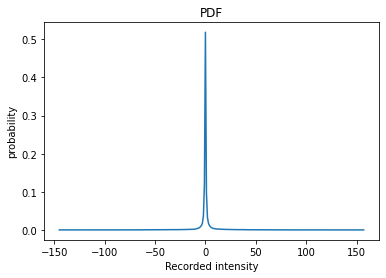

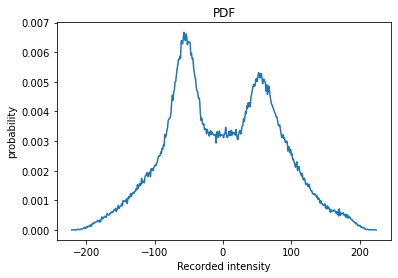

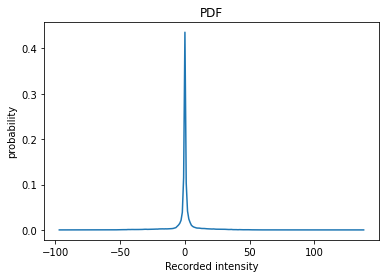

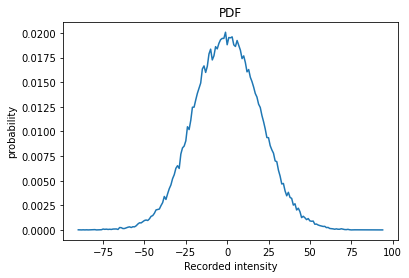

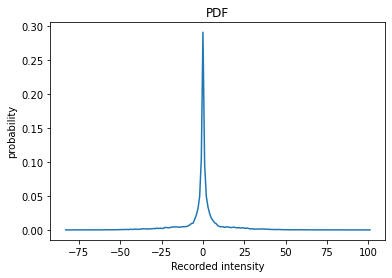

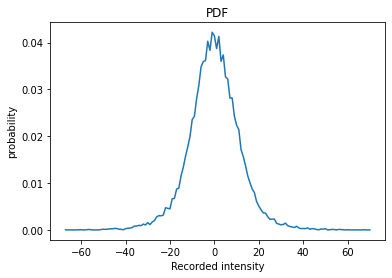

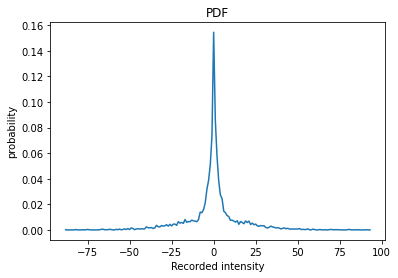

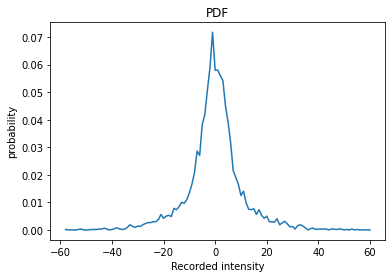

In [16]:
# 原图与噪声图的对比：
ori_pdf = []
noise_pdf = []
for i in range(len(hist)-1):
    t = PDF(hist[i],min_l[i],max_l[i])
    ori_pdf.append(t)
    tt = PDF(hist00[i],min_ll[i],max_ll[i])
    noise_pdf.append(tt)

In [17]:
# calculate CDF: C(I) = 1/N*sum(0,I)h(i)
def CDF(hist,min,max):
    sum = np.sum(hist)
    cdf = []
    length = len(hist)
    for i in range(length):
        cdf.append(np.sum(hist[0:i])/sum)
    plt.plot(np.arange(min,max+1),cdf)
    plt.title("CDF")
    plt.show()
    return np.array(cdf)

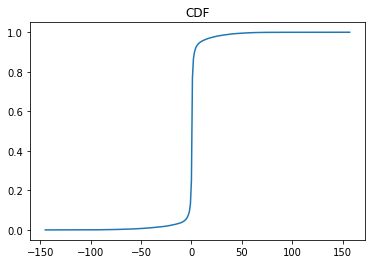

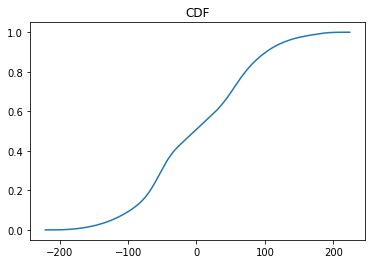

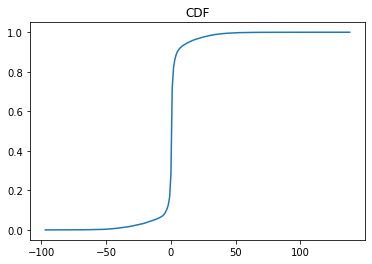

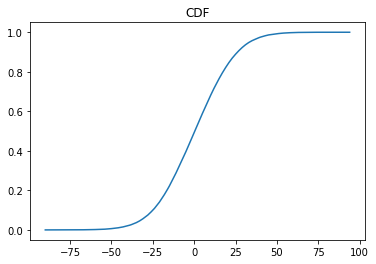

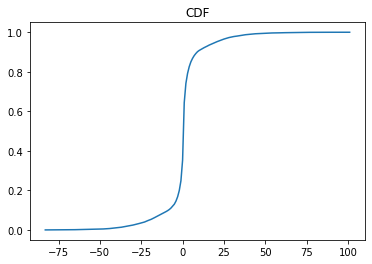

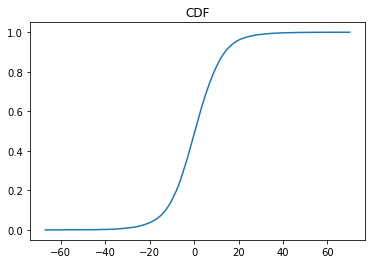

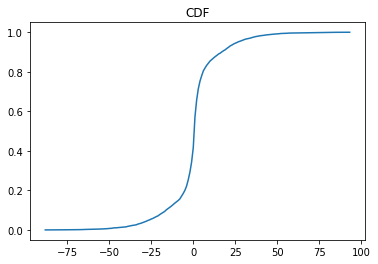

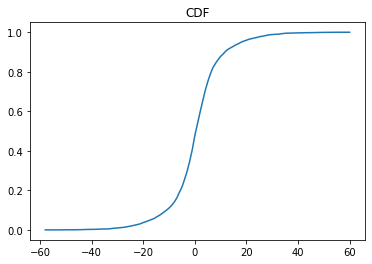

In [18]:
# 原图与噪声图的对比：
ori_cdf = []
noise_cdf = []
for i in range(len(hist)-1):
    t = CDF(hist[i],min_l[i],max_l[i])
    ori_cdf.append(t)
    tt = CDF(hist00[i],min_ll[i],max_ll[i])
    noise_cdf.append(tt)

In [19]:
# 计算半高全宽
def cal_FWHM(hist_pdf,lap_pyr,min,max):
    # 拟合laplacian distribution
    # 转为一维数据：
    data = list(lap_pyr.flatten())
    # 计算各项参数
    loc,scale = laplace.fit(data)
    m,v,s,k=laplace.stats(loc=loc,scale=scale,moments='mvsk')
    # 使用方差计算半高全宽以及阈值：
    std = v**0.5
    FWHM = 2*(2*np.log(2))**0.5*std
    threshold = FWHM/2
    # 展示：
    x = np.arange(min,max+1,1)
    plt.figure()
    plt.plot(x,hist_pdf)
    plt.axvline(threshold,c="r")
    plt.axvline(-1*threshold,c="r")
    plt.show()

    return threshold

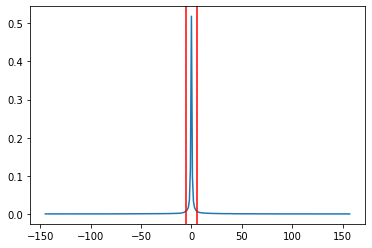

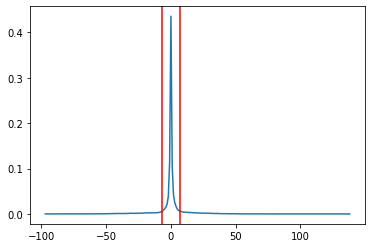

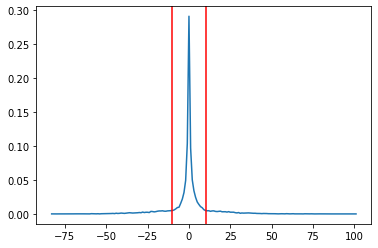

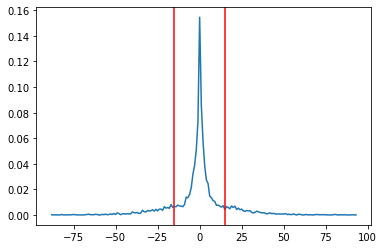

In [20]:
# 计算每一层的半高全宽/2：
ori_FWHM = []
for i in range(len(img0_lap_pyr)-1):
    ori_FWHM.append(cal_FWHM(ori_pdf[i],img0_lap_pyr[i],min_l[i],max_l[i]))

In [21]:
# 计算半高全宽对应的比例：
def cal_threshold(ori_FWHM,ori_cdf,noise_pdf,noise_cdf,min_l,min_ll,max_ll):

    # 左半边的比例：
    l_p = ori_cdf[int(-1*min_l)]-ori_cdf[int(-1*ori_FWHM-min_l)]
    # 右半边的比例：
    r_p = ori_cdf[int(ori_FWHM-min_l)]-ori_cdf[int(-1*min_l)]
    p = (l_p+r_p)/2

    # 阈值：
    zero_cdf = noise_cdf[int(-1*min_ll)]
    l_t,r_t = 0,0
    # 左半边：
    for i in range(len(noise_cdf)):
        if noise_cdf[i]<zero_cdf:
            if zero_cdf - noise_cdf[i] < p:
                l_t = i
                print("left:",i)
                break
    # 右半边：
    for i in range(len(noise_cdf)):
        if noise_cdf[i]>zero_cdf:
            if noise_cdf[i]- zero_cdf > p:
                print("right:",i)
                r_t = i
                break

    # 展示：
    x = np.arange(min_ll,max_ll+1,1)
    plt.figure()
    plt.plot(x,noise_pdf)
    plt.axvline(l_t+min_ll,c="r")
    plt.axvline(r_t+min_ll,c="r")
    plt.show()

    return l_t,r_t

left: 110
right: 347


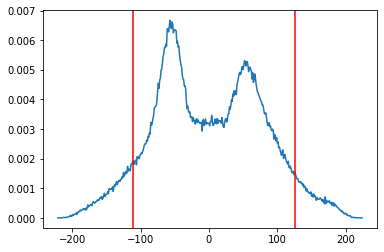

left: 62
right: 119


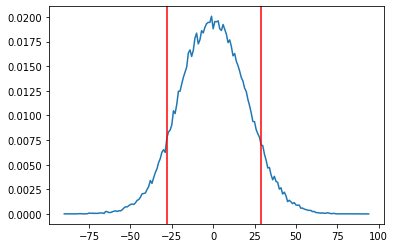

left: 53
right: 81


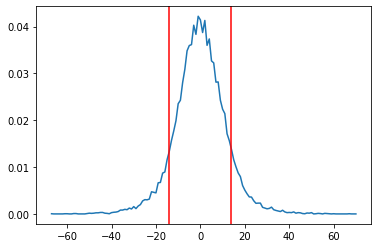

left: 46
right: 68


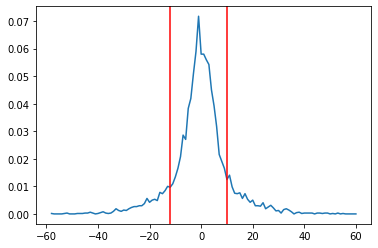

In [22]:
thresold = []
for i in range(len(ori_FWHM)):
    l_t,r_t = cal_threshold(ori_FWHM[i],ori_cdf[i],noise_pdf[i],noise_cdf[i],min_l[i],min_ll[i],max_ll[i])
    thresold.append((l_t,r_t))

In [23]:
# 将范围内的像素点全部改为0：
def zero_map(cdf,lap_pyr,l_t,r_t,min_ll):
    img_pure = np.array(lap_pyr) # copy
    # coeffiency:
    gray_l = l_t+min_ll
    print(gray_l)
    gray_r = r_t+min_ll
    print(gray_r)
    # 取交集：
    gray = np.arange(gray_l,gray_r,1)
    for i in gray:
        # index:
        res = np.where(lap_pyr==i)
        if len(res) ==0:
            continue
        x,y = res
        # map:
        for j in range(len(x)):
            img_pure[x[j]][y[j]] = 0
    return img_pure

0
-111.0
126.0


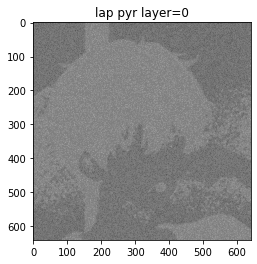

1
-28.0
29.0


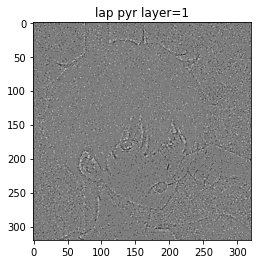

2
-14.0
14.0


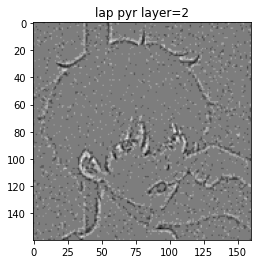

3
-12.0
10.0


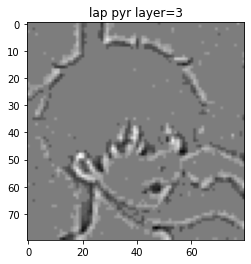

In [24]:
pure_lap_pyr = []
for i in range(len(noise_cdf)):
    print(i)
    t = zero_map(noise_cdf[i],img00_lap_pyr[i],thresold[i][0],thresold[i][1],min_ll[i])
    pure_lap_pyr.append(t)
    # 展示：
    plt_show("lap pyr layer={}".format(i),t,cmap="gray")
pure_lap_pyr.append(int2uint(img00_lap_pyr[level]))

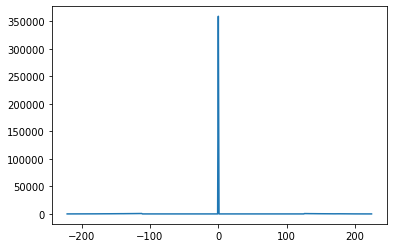

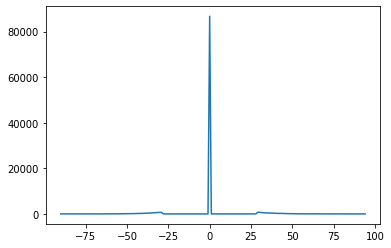

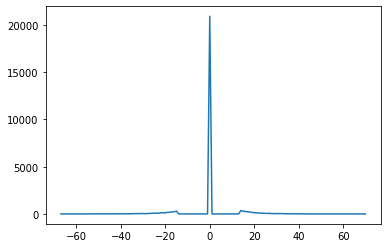

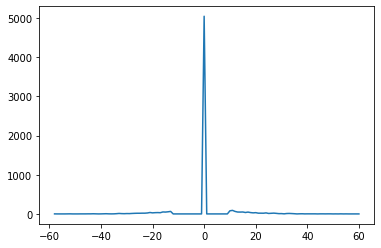

In [25]:
# 画直方图：
h_p,min_p,max_p = histogram(pure_lap_pyr[:-1])

In [26]:
# 重构图像：
def reconstruct(blended_pyr):
    reconstruct_pyr = []
    add = np.array(blended_pyr[len(blended_pyr)-1])
    for i in range(len(blended_pyr)-1,0,-1):
        # extend
        temp = cv2.pyrUp(add)
        # add:
        width = min(temp.shape[0],blended_pyr[i-1].shape[0])
        length = min(temp.shape[1],blended_pyr[i-1].shape[1])
        print(temp.shape[0],blended_pyr[i-1].shape[0])
        a = np.array(temp[:width,:length],dtype='int')
        b = np.array(blended_pyr[i-1][:width,:length],dtype='int')
        add = int2uint(a+b)
        
        reconstruct_pyr.append(add)
        # show
        plt_show("layer={}".format(i),add,cmap="gray")

    return reconstruct_pyr

80 80


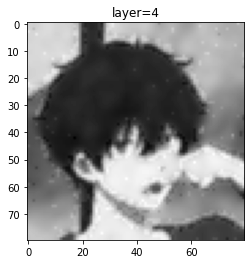

160 160


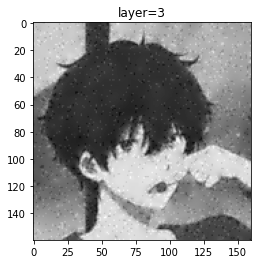

320 320


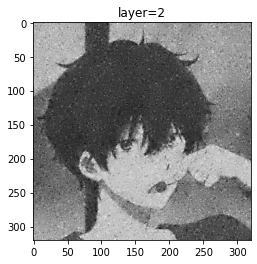

640 640


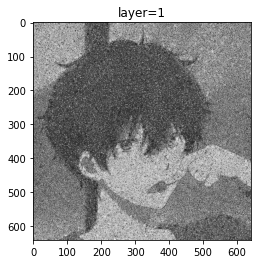

In [27]:
re_pyr = reconstruct(pure_lap_pyr)

In [28]:
def process(img_gray):
    # 高斯金字塔：
    img_gauss_pyr = gauss_pyramid(img_gray,level)
    # 拉普拉斯金字塔：
    img_lap_pyr = lap_pyramid(img_gauss_pyr,level)
    # 直方图：
    hist,min_l,max_l = histogram(img_lap_pyr)
    # 加入高斯噪声：
    img_noise_gray = add_GaussNoise(img_gray)
    # 重复以上：
    img_noise_gauss_pyr = gauss_pyramid(img_noise_gray,level)
    img_noise_lap_pyr = lap_pyramid(img_noise_gauss_pyr,level)
    hist_noise,min_ll,max_ll= histogram(img_noise_lap_pyr)
    # 计算pdf
    ori_pdf = []
    noise_pdf = []
    for i in range(len(hist)-1):
        t = PDF(hist[i],min_l[i],max_l[i])
        ori_pdf.append(t)
        tt = PDF(hist_noise[i],min_ll[i],max_ll[i])
        noise_pdf.append(tt)
    # 计算cdf:
    ori_cdf = []
    noise_cdf = []
    for i in range(len(hist)-1):
        t = CDF(hist[i],min_l[i],max_l[i])
        ori_cdf.append(t)
        tt = CDF(hist_noise[i],min_ll[i],max_ll[i])
        noise_cdf.append(tt)
    # 计算半高全宽：
    ori_FWHM = []
    for i in range(len(img_lap_pyr)-1):
        ori_FWHM.append(cal_FWHM(ori_pdf[i],img_lap_pyr[i],min_l[i],max_l[i]))
    # 计算阈值：
    thresold = []
    for i in range(len(ori_FWHM)):
        l_t,r_t = cal_threshold(ori_FWHM[i],ori_cdf[i],noise_pdf[i],noise_cdf[i],min_l[i],min_ll[i],max_ll[i])
        thresold.append((l_t,r_t))
    # map zero：
    pure_lap_pyr = []
    for i in range(len(noise_cdf)):
        t = zero_map(noise_cdf[i],img_noise_lap_pyr[i],thresold[i][0],thresold[i][1],min_ll[i])
        pure_lap_pyr.append(t)
        # 展示：
        plt_show("lap pyr layer={}".format(i),t,cmap="gray")
    pure_lap_pyr.append(int2uint(img_noise_lap_pyr[level]))
    # 画直方图：
    h_p,min_p,max_p = histogram(pure_lap_pyr[:-1])
    # 重构：
    re_pyr = reconstruct(pure_lap_pyr)

    return re_pyr

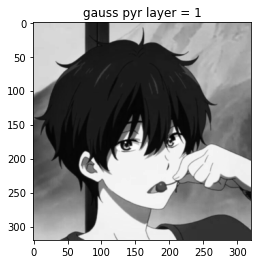

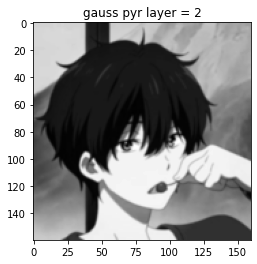

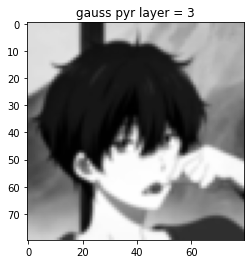

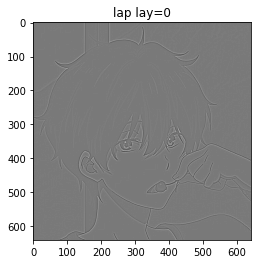

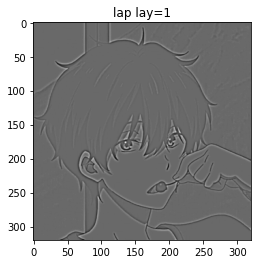

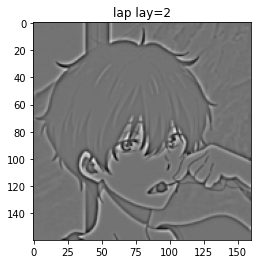

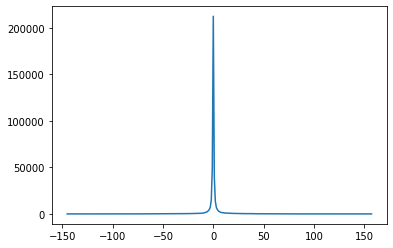

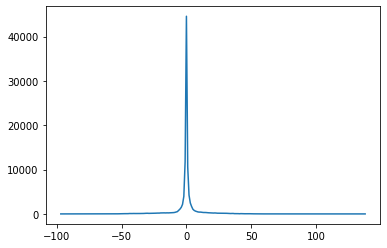

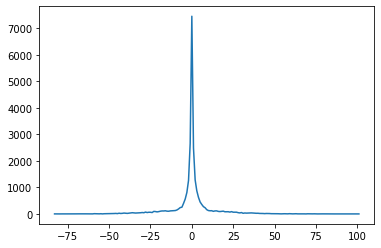

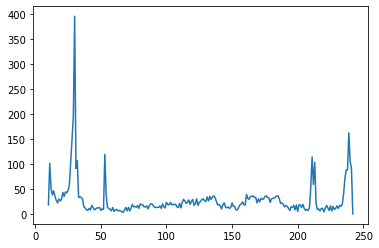

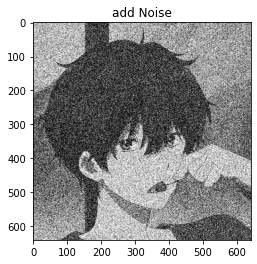

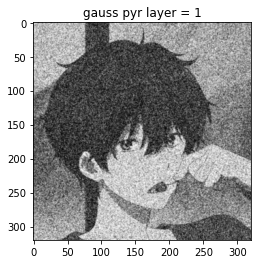

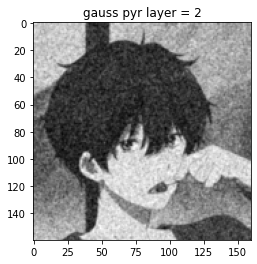

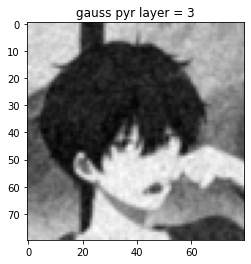

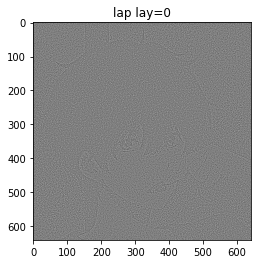

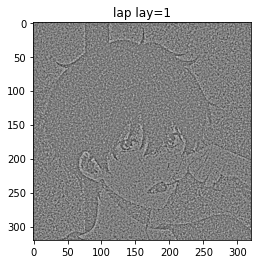

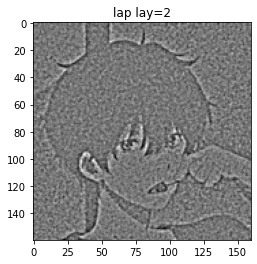

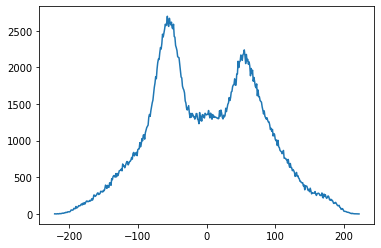

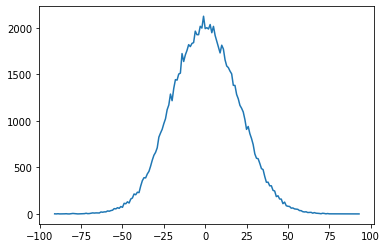

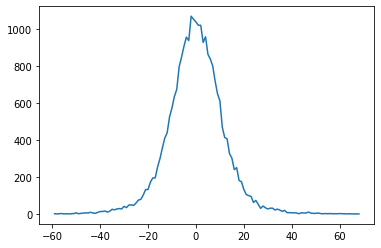

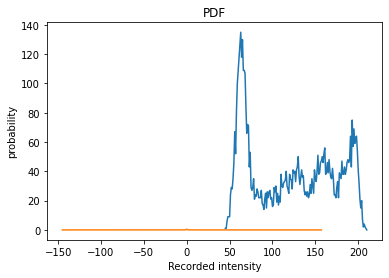

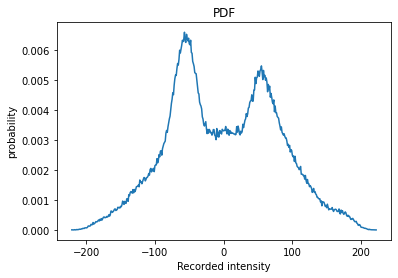

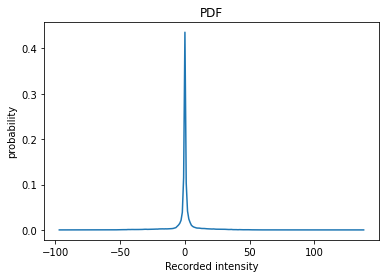

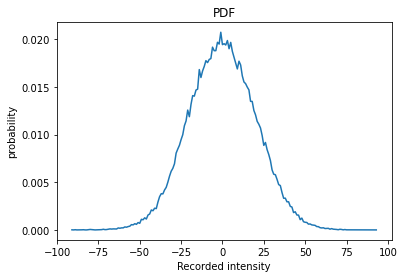

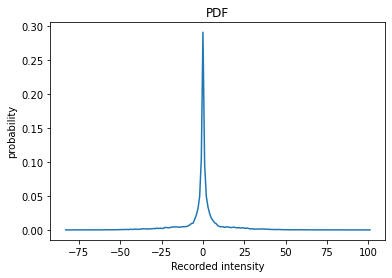

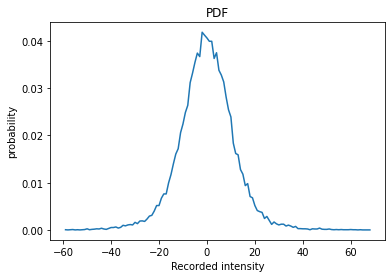

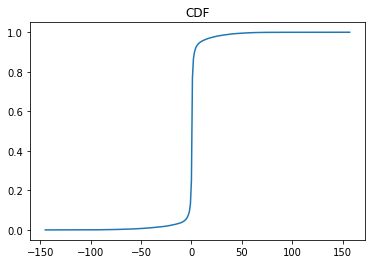

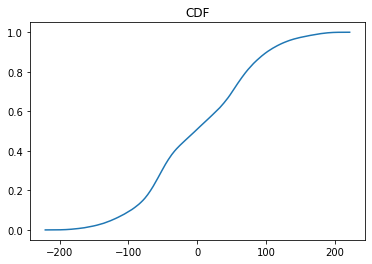

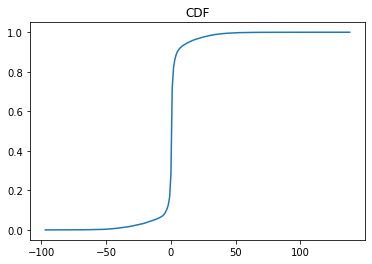

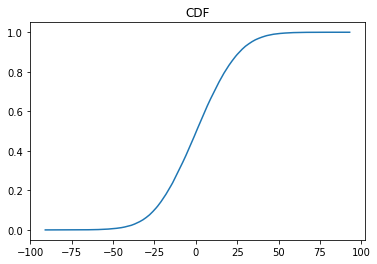

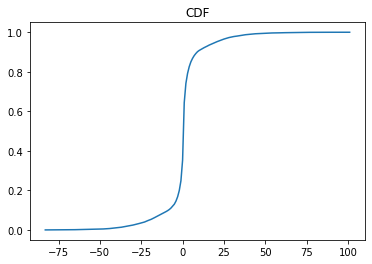

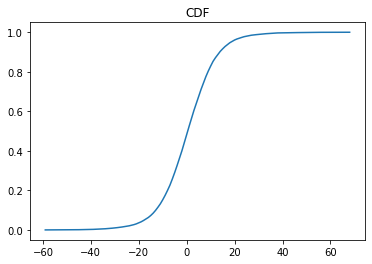

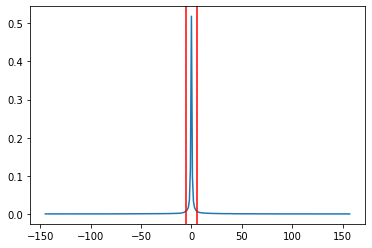

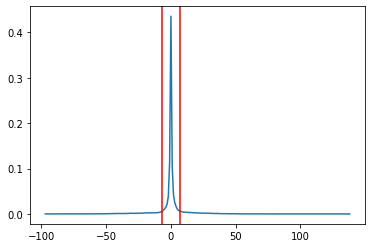

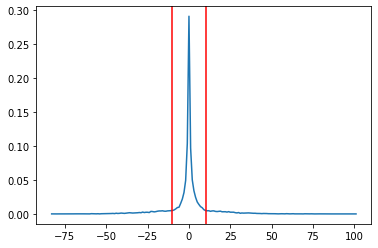

left: 110
right: 348


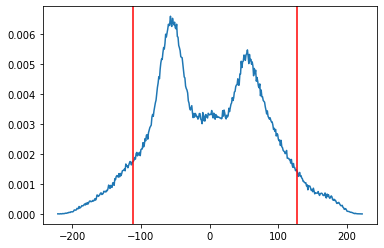

left: 63
right: 120


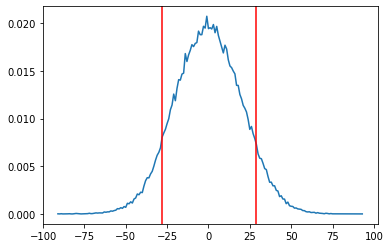

left: 45
right: 73


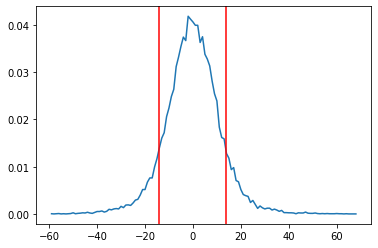

-111.0
127.0


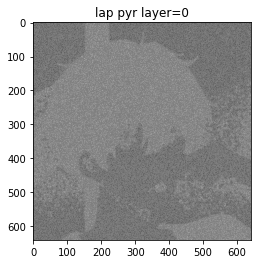

-28.0
29.0


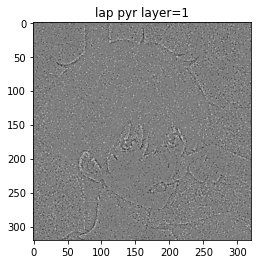

-14.0
14.0


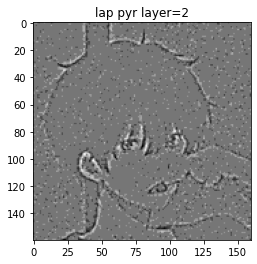

160 160


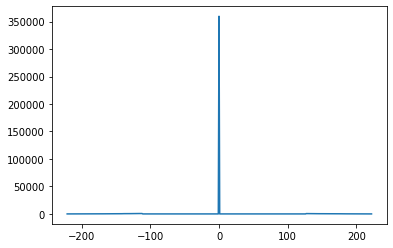

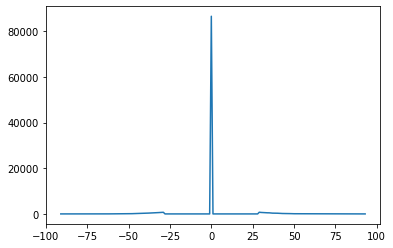

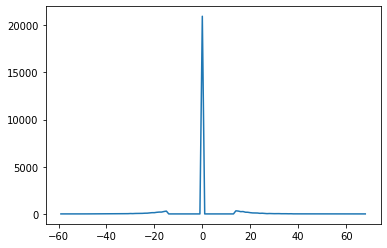

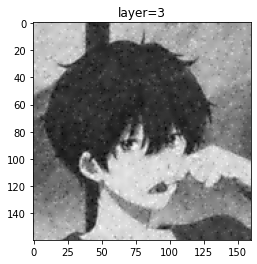

320 320


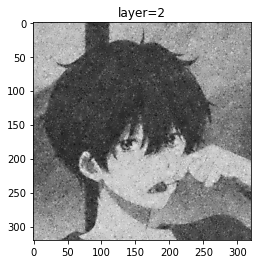

640 640


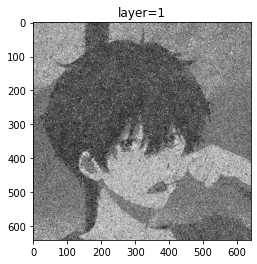

In [29]:
level = 3
re_pyr = process(img0_gray)